In [1]:
import yaml
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from matplotlib import pyplot as plt
import pickle

In [2]:
# Read config file
with open("config.yaml", 'r') as configuration:
    config = yaml.safe_load(configuration)

In [3]:
# Read and concat the data
PL_20_21 = pd.read_csv('data\\PL_20_21.csv', sep=';')
PL_19_20 = pd.read_csv('data\\PL_19_20.csv', sep=';')
PL_18_19 = pd.read_csv('data\\PL_18_19.csv', sep=';')
PL_17_18 = pd.read_csv('data\\PL_17_18.csv', sep=';')
BL_20_21 = pd.read_csv('data\\BL_20_21.csv', sep=';')
BL_19_20 = pd.read_csv('data\\BL_19_20.csv', sep=';')
BL_18_19 = pd.read_csv('data\\BL_18_19.csv', sep=';')
SP_20_21 = pd.read_csv('data\\SP_20_21.csv', sep=';')
SP_19_20 = pd.read_csv('data\\SP_19_20.csv', sep=';')
SP_18_19 = pd.read_csv('data\\SP_18_19.csv', sep=';')
SP_17_18 = pd.read_csv('data\\SP_17_18.csv', sep=';')
IT_20_21 = pd.read_csv('data\\IT_20_21.csv', sep=';')


data = pd.concat([PL_20_21,PL_19_20,PL_18_19,PL_17_18,BL_20_21,BL_19_20,BL_18_19,SP_20_21,SP_19_20,SP_18_19,SP_17_18,IT_20_21])
data = data.reset_index(drop=True)
data = data.dropna(how='any')
data

,Date,HomeTeam,AwayTeam,FTR,h_course,d_course,a_course,h_pts_3,h_pts_5,h_pts_7,...,a_rc_5,a_rc_7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja
1,2020-09-26,Crystal Palace,Everton,A,3.75,3.25,2.10,1.000000,0.8,1.000000,...,0.0,0.000000,3.000000,3.000000,1.000000,16.000000,7.500000,8.000000,2.000000,2.0
2,2020-09-26,West Brom,Chelsea,D,9.00,4.75,1.36,0.666667,1.0,1.142857,...,0.0,0.142857,1.500000,1.500000,1.500000,7.500000,15.500000,2.500000,7.000000,9.0
4,2020-09-27,Sheffield United,Leeds,A,2.70,3.30,2.62,1.000000,0.6,0.428571,...,0.2,0.142857,1.500000,3.500000,3.500000,8.000000,18.000000,7.000000,1.500000,8.0
5,2020-09-27,Tottenham,Newcastle,D,1.45,4.50,7.00,2.000000,1.4,1.571429,...,0.2,0.142857,1.500000,1.000000,1.500000,10.500000,14.000000,7.500000,4.000000,12.0
7,2020-09-27,West Ham,Wolves,H,3.60,3.50,2.05,1.000000,1.2,1.428571,...,0.0,0.000000,1.500000,1.500000,1.500000,10.500000,11.500000,8.000000,5.500000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,2020-10-17,Sampdoria,Lazio,H,3.30,3.50,2.15,2.333333,2.0,1.857143,...,0.4,0.285714,1.333333,1.333333,1.666667,10.333333,9.000000,5.666667,5.666667,10.0
3870,2020-10-17,Crotone,Juventus,D,6.50,4.50,1.45,1.666667,1.0,1.142857,...,0.2,0.142857,2.000000,2.500000,1.000000,10.000000,8.500000,5.500000,5.500000,9.0
3871,2020-10-18,Bologna,Sassuolo,A,2.90,3.60,2.30,0.333333,0.6,0.571429,...,0.4,0.285714,2.333333,3.000000,1.000000,12.666667,9.666667,4.333333,4.000000,4.0
3872,2020-10-18,Spezia,Fiorentina,D,5.25,4.00,1.61,1.666667,1.2,1.000000,...,0.2,0.142857,1.000000,1.666667,2.000000,13.666667,10.666667,5.666667,2.000000,13.0


In [4]:
# Dictionary for mapping target
str2idx = {'H':0, 'D':1, 'A':2}
idx2str = {0:'H', 1:'D', 2:'A'}
dicts2translate = {'str2idx' : str2idx,
                   'idx2str' : idx2str }

data = data.replace({'FTR': str2idx})

data_label = data['FTR']
data = data.drop(['FTR','Date','HomeTeam','AwayTeam'], axis=1)
data

,h_course,d_course,a_course,h_pts_3,h_pts_5,h_pts_7,h_gz_3,h_gz_5,h_gz_7,h_gs_3,...,a_rc_5,a_rc_7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja
1,3.75,3.25,2.10,1.000000,0.8,1.000000,1.000000,1.0,1.000000,1.333333,...,0.0,0.000000,3.000000,3.000000,1.000000,16.000000,7.500000,8.000000,2.000000,2.0
2,9.00,4.75,1.36,0.666667,1.0,1.142857,1.333333,1.4,1.714286,2.000000,...,0.0,0.142857,1.500000,1.500000,1.500000,7.500000,15.500000,2.500000,7.000000,9.0
4,2.70,3.30,2.62,1.000000,0.6,0.428571,0.333333,0.2,0.285714,2.000000,...,0.2,0.142857,1.500000,3.500000,3.500000,8.000000,18.000000,7.000000,1.500000,8.0
5,1.45,4.50,7.00,2.000000,1.4,1.571429,2.333333,2.0,2.000000,1.333333,...,0.2,0.142857,1.500000,1.000000,1.500000,10.500000,14.000000,7.500000,4.000000,12.0
7,3.60,3.50,2.05,1.000000,1.2,1.428571,0.666667,1.4,1.857143,1.000000,...,0.0,0.000000,1.500000,1.500000,1.500000,10.500000,11.500000,8.000000,5.500000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,3.30,3.50,2.15,2.333333,2.0,1.857143,2.000000,1.8,1.428571,0.666667,...,0.4,0.285714,1.333333,1.333333,1.666667,10.333333,9.000000,5.666667,5.666667,10.0
3870,6.50,4.50,1.45,1.666667,1.0,1.142857,1.000000,0.6,1.000000,0.666667,...,0.2,0.142857,2.000000,2.500000,1.000000,10.000000,8.500000,5.500000,5.500000,9.0
3871,2.90,3.60,2.30,0.333333,0.6,0.571429,1.000000,1.4,1.142857,2.666667,...,0.4,0.285714,2.333333,3.000000,1.000000,12.666667,9.666667,4.333333,4.000000,4.0
3872,5.25,4.00,1.61,1.666667,1.2,1.000000,2.666667,2.0,1.571429,1.666667,...,0.2,0.142857,1.000000,1.666667,2.000000,13.666667,10.666667,5.666667,2.000000,13.0


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.30, random_state=20)

X_train = xgb.DMatrix(X_train, label=y_train)

X_test = xgb.DMatrix(X_test, label=y_test)

In [6]:
# Parameters definition
param = {'max_depth': 3,
         'eta': 0.003,
         'gamma':4,
         'min_child_weight':40,
         'colsample_bytree':0.6,
         'subsample':0.9,
         'lambda':0.9,
         'objective': 'multi:softprob',
         'eval_metric' : ['auc','merror'],
         'num_class' : 3
        }
evallist = [(X_test, 'test'), (X_train, 'train')]

xgb_model = xgb.train(param, X_train, 50, evallist)

[0]	test-auc:0.68985	test-merror:0.47814	train-auc:0.69572	train-merror:0.46896
[1]	test-auc:0.69868	test-merror:0.47268	train-auc:0.70294	train-merror:0.46544
[2]	test-auc:0.69763	test-merror:0.47450	train-auc:0.70537	train-merror:0.46193
[3]	test-auc:0.69579	test-merror:0.47450	train-auc:0.70674	train-merror:0.46622
[4]	test-auc:0.69569	test-merror:0.47359	train-auc:0.70862	train-merror:0.46232
[5]	test-auc:0.69307	test-merror:0.47541	train-auc:0.71365	train-merror:0.46193
[6]	test-auc:0.69426	test-merror:0.47450	train-auc:0.71308	train-merror:0.45842
[7]	test-auc:0.69583	test-merror:0.47268	train-auc:0.71536	train-merror:0.46037
[8]	test-auc:0.69725	test-merror:0.47268	train-auc:0.71563	train-merror:0.45646
[9]	test-auc:0.69906	test-merror:0.47450	train-auc:0.71606	train-merror:0.45763
[10]	test-auc:0.70090	test-merror:0.47359	train-auc:0.71810	train-merror:0.45998
[11]	test-auc:0.70059	test-merror:0.47541	train-auc:0.71791	train-merror:0.45998
[12]	test-auc:0.70099	test-merror:0.47

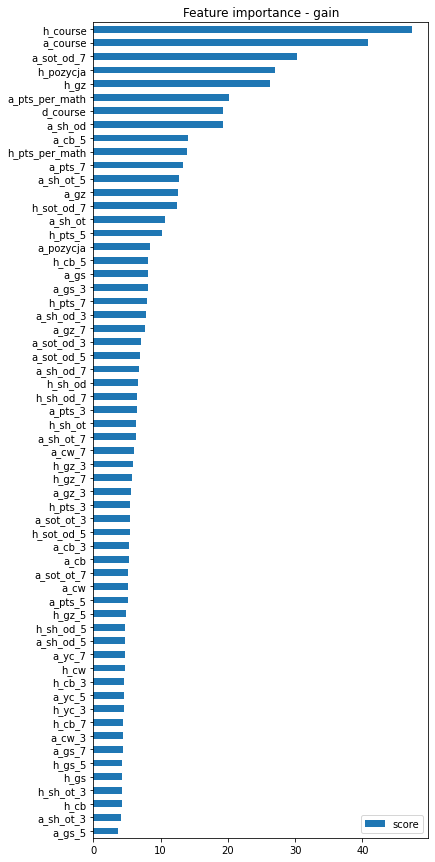

In [7]:
# Feature importance
feature_important = xgb_model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_score = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data_score.plot(kind='barh', figsize=(6,15))
plt.title('Feature importance - gain')
plt.show()

In [8]:
train_probabilities = pd.DataFrame(xgb_model.predict(X_train))
#train_preds['FTR'] = train_preds.idxmax(axis = 1)
#train_preds = train_preds.replace({'FTR': idx2str})

test_probabilities = pd.DataFrame(xgb_model.predict(X_test))
#test_preds['FTR'] = test_preds.idxmax(axis = 1)
#test_preds = test_preds.replace({'FTR': idx2str})

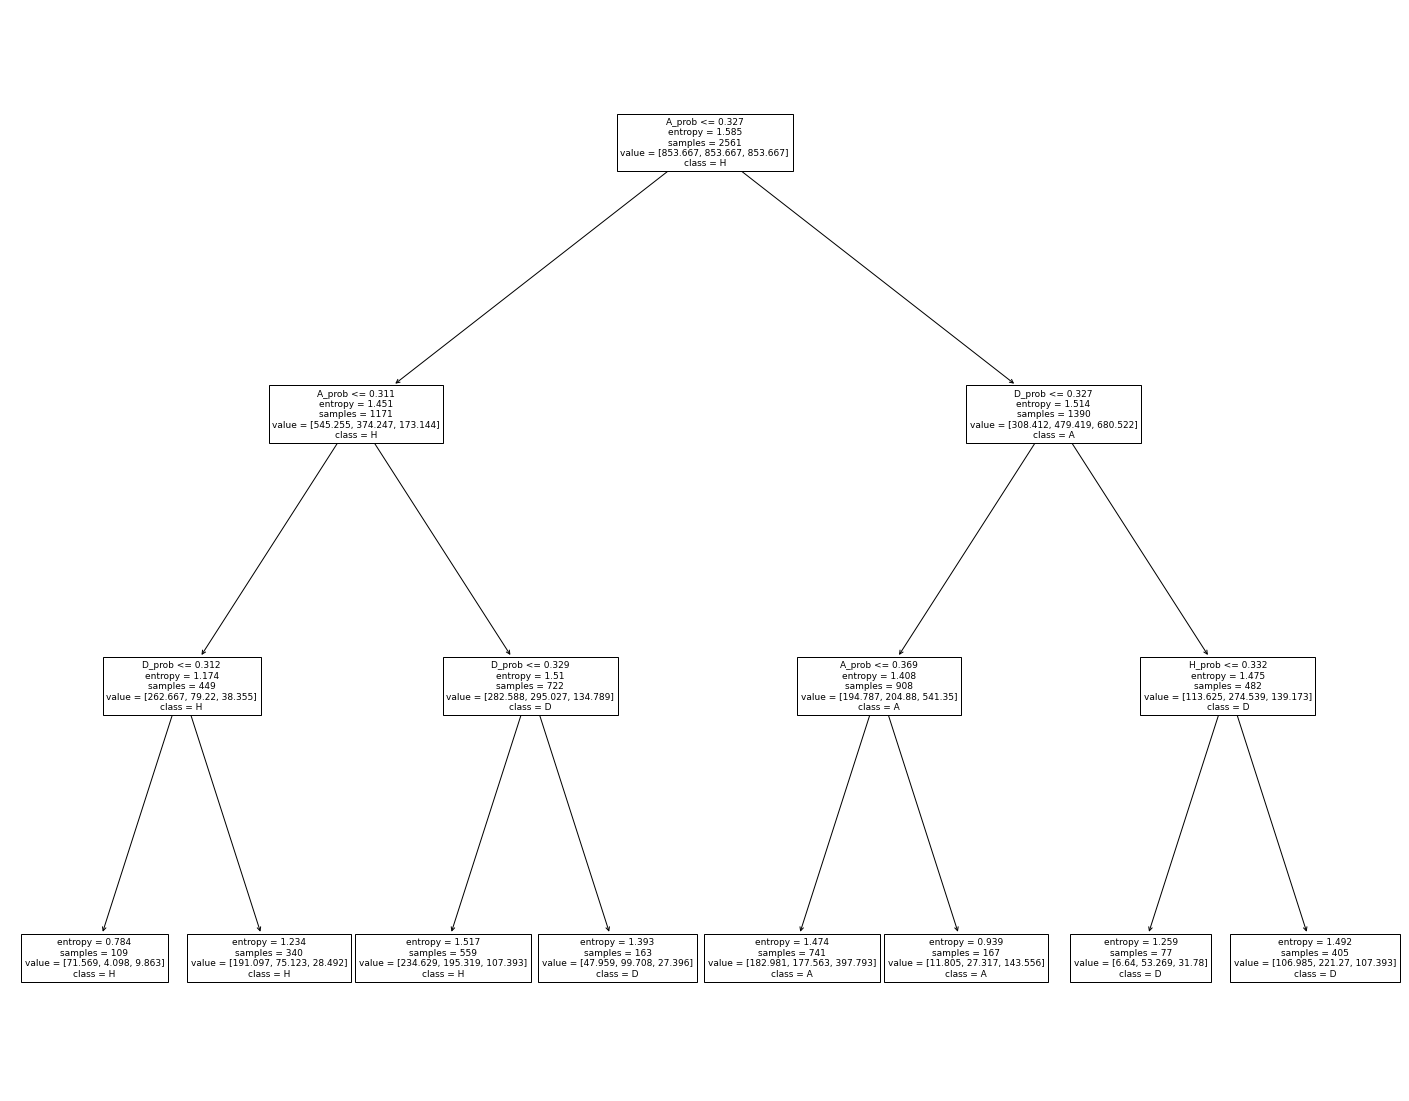

In [9]:
# Decision tree
decision_tree = DecisionTreeClassifier(criterion='entropy',
                             class_weight = 'balanced',
                             max_depth = 3,
                             min_samples_leaf = 0.03
                            )
decision_tree.fit(train_probabilities, np.array(y_train))

# Plot tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree, 
                   feature_names=['H_prob','D_prob','A_prob'],
                   class_names=['H','D','A'])

In [10]:
# Predictions after decision tree
tree_preds_train = decision_tree.predict(train_probabilities)
tree_preds_test = decision_tree.predict(test_probabilities)

In [11]:
# ACCURACY
print('TRAIN:', sum(np.array(tree_preds_train) == np.array(y_train))/len(np.array(y_train)))
print('TEST:', sum(np.array(tree_preds_test) == np.array(y_test))/len(np.array(y_test)))

# Confucion matrix
print('TRAIN:\n', confusion_matrix(np.array(y_train), np.array(tree_preds_train)))
print('TEST:\n', confusion_matrix(np.array(y_test), np.array(tree_preds_test)))

TRAIN: 0.5630613041780554
TEST: 0.517304189435337
TRAIN:
 [[674 219 264]
 [201 274 150]
 [133 152 494]]
TEST:
 [[271  96  94]
 [ 92  95 101]
 [ 58  89 202]]


In [12]:
# Save model and components
pickle.dump(xgb_model, open('model\\xgb_model.pkl', "wb"))
pickle.dump(decision_tree, open('model\\tree_model.pkl', "wb"))
pickle.dump(dicts2translate, open('model\\dicts2translate.pkl', "wb"))